**Q3. Policy-based methods with linear function approximation [40 points]**

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
class tilecoding:
  def __init__(self, env, num_tile, bins):
    self.env = env
    self.obs_dim = env.observation_space.shape[0]
    self.bins = bins
    self.num_tile = num_tile
    self.numTiles = (self.bins**self.obs_dim) * self.num_tile


  def tiles_grid(self, offset_pos):
    min_pos, min_vel, min_angle, min_v_angle = self.env.observation_space.low
    max_pos, max_vel, max_angle, max_v_angle = self.env.observation_space.high
    bins = self.bins

    pos_grid =  np.linspace(min_pos, max_pos, bins )[1:-1] +  offset_pos[0]#np.concatenate((np.array([min_pos]), np.linspace(-2, 2, bins)[0:-1], np.array([max_pos])))
    angle_grid = np.linspace(min_angle, max_angle, bins )[1:-1] + + offset_pos[2] #np.concatenate((np.array([min_angle]), np.linspace(-0.3, 0.3, bins)[0:-1], np.array([max_angle])))
    vel_grid = np.concatenate((np.array([min_vel]), np.linspace(-5, 5, bins)[2:-2], np.array([max_vel])))+ offset_pos[1]
    angle_vel_grid = np.concatenate((np.array([-9999]), np.linspace(-5, 5, bins)[2:-2], np.array([9999]))) + + offset_pos[3]
    grid = [pos_grid, vel_grid, angle_grid, angle_vel_grid ]
    return grid #np.array(grid).flatten()
  
  def create_tilings(self):
    high = np.array([2.5, 5, 0.42, 5])
    low = np.array([-2.5, -5, -0.42, -5])
    offset_pos = (high - low)/(self.num_tile*self.bins)
    n = self.num_tile // 2
    num = -n*offset_pos
    #print(num)
    tiling_specs = [-n*offset_pos]
    for i in range(self.num_tile - 1):
      num += offset_pos
      #print(num)
      tiling_specs.append(num)

    
    #tiling_specs = [-offset_pos, tuple([0.0]*self.env.observation_space.shape[0]), offset_pos]
    #print([print(offsets) for offsets in tiling_specs])
    return [self.tiles_grid(offsets) for offsets in tiling_specs]

  def discretize(self, obs, tile_grid):
    encode = []
    for grids in tile_grid:
      #tile_grid = np.array(tile_grid).reshape(self.obs_dim, -1)
      position_tuple = tuple(int(np.digitize(state, grid)) for state, grid in zip(obs, grids))
      #print(position_tuple)
      array = []
      for i in range(self.obs_dim):
        state = [0]*self.bins
        state[position_tuple[i] - 1] = 1
        array.append(state)
      encode.append(array)
    return np.array(encode).flatten()


class tilecoding_Mountain:
  def __init__(self, env, num_tile, bins):
    self.env = env
    self.obs_dim = env.observation_space.shape[0]
    self.bins = bins
    self.num_tile = num_tile
    #bins = tuple([bins]*env.observation_space.shape[0])
    self.numTiles = (self.bins**self.obs_dim) * self.num_tile


  def tiles_grid(self, offset_pos):
    #print(offset_pos)
    min_pos, min_vel  = self.env.observation_space.low
    max_pos, max_vel = self.env.observation_space.high
    bins = self.bins

    pos_grid =  np.linspace(min_pos, max_pos, bins + 1)[1:-1] + offset_pos[0]
    vel_grid = np.linspace(min_vel, max_vel, bins + 1)[1:-1] + offset_pos[1]

    grid = [pos_grid, vel_grid]
    return grid #np.array(grid).flatten()
  
  def create_tilings(self):
    offset_pos = (self.env.observation_space.high - self.env.observation_space.low)/(self.num_tile*self.bins)
    n = self.num_tile // 2
    num = -n*offset_pos
    tiling_specs = [-n*offset_pos]
    for i in range(self.num_tile - 1):
      num += offset_pos
      tiling_specs.append(num)

    
    #tiling_specs = [-offset_pos, tuple([0.0]*self.env.observation_space.shape[0]), offset_pos]
    #print(tiling_specs)

    return [self.tiles_grid(offsets) for offsets in tiling_specs]

  def discretize(self, obs, tile_grid):
    encode = []
    for grids in tile_grid:
      #tile_grid = np.array(tile_grid).reshape(self.obs_dim, -1)
      position_tuple = tuple(int(np.digitize(state, grid)) for state, grid in zip(obs, grids))
      #print(position_tuple)
      array = []
      for i in range(self.obs_dim):
        state = [0]*self.bins
        state[position_tuple[i] - 1] = 1
        array.append(state)
      encode.append(array)
    #print(np.array(encode).flatten())
    return np.array(encode).flatten()#np.array(array_160d).reshape(-1, 4)



In [4]:
def Boltzmann(z, temp):
    '''
    temp: temperature
    z: linear appximation for z
    '''
    z_max = np.max(z, axis=0, keepdims=True)
    e_z = np.exp( (z - z_max) / temp)
    return e_z / e_z.sum(axis=0)

In [26]:
class REINFORCE:
  def __init__(self, env, bins, num_tiles, gamma):
    self.state_num = env.observation_space.shape[0]
    self.action_num = env.action_space.n
    self.w = np.random.uniform(-0.001, 0.001, (self.state_num*bins*num_tiles, self.action_num))
    self.w2 = np.random.uniform(-0.001, 0.001, self.state_num*bins*num_tiles)
    self.gamma = gamma

  def policy(self, z, temp):
    probs = Boltzmann(z, temp)
    highest_prob_action = np.random.choice(range(0, self.action_num), p = probs)
    return highest_prob_action, probs[highest_prob_action]
  
  def apply_weight(self, state): #dot product for linear approximation function with weights vector
    return np.dot(state, self.w)

  def apply_w(self, state):  # Baseline value function approximation
    return np.dot(state, self.w2) 

  def update_gradient(self, alpha, reward, prob, state, action):
    for t in range(len(reward)):
        Gt = sum([self.gamma ** i * reward[t + i] for i in range(len(reward) - t)])
        baseline = self.apply_w2(state[t])
        delta = Gt - baseline  # The advantage adjustment

        # Gradient for policy weights
        grad = alpha * self.gamma ** t * delta * state[t] * (1 - prob[t])
        self.w[:, action[t]] += grad

        # Update the baseline weights
        self.w2 += alpha * delta * state[t]

In [27]:
def REINFORCE_implement(env, tile, alpha, temp, bins, num_tiles, gamma = 0.99):
  trial_reward = []
  for j in range(trials):
    REINFORCE_Imp = REINFORCE(env, bins, num_tiles, gamma)
    tiling = tile
    tile_grids = tiling.create_tilings()
    rewards = []
    for i in range(episodes):
      reward_list = []
      prob_list = []
      state_list = []
      action_list = []
      done = False
      s = env.reset()
      state_encoding = tiling.discretize(s, tile_grids)
      z = REINFORCE_Imp.apply_weight(state_encoding)
      for max in range(env._max_episode_steps):
        a, log_prob = REINFORCE_Imp.policy(z, temp[i])
        s, reward, done, _ = env.step(a)
        state_list.append(state_encoding)
        action_list.append(a)
        next_s = tiling.discretize(s, tile_grids)
        state_encoding = next_s
        z = REINFORCE_Imp.apply_weight(state_encoding)
        reward_list.append(reward)
        prob_list.append(log_prob)
        if done:
          REINFORCE_Imp.update_gradient(alpha, reward_list, prob_list, state_list, action_list)
          break
      rewards.append(np.sum(reward_list))
    trial_reward.append(rewards)

  return trial_reward



In [14]:
env = gym.make("CartPole-v1")
obs = env.reset()

#define the parameters
temp = [0.1, 1]
bins = 10
num_tiles = 2
alpha = [1e-5, 1e-4]
trials = 5
gamma = 0.99
episodes = 1000


In [ ]:
CP_RF_return = []
for i in range(2):
  learning_return = []
  for a in range(len(alpha)):
    if i == 0:
      temp = np.ones(episodes)*temp[0]
    else:
      temperature = np.linspace(0.1, 0.01, episodes)
    avg_return = REINFORCE_implement(env, tilecoding(env,num_tiles, bins), alpha[a], temp, num_tiles, bins)
    learning_return.append(avg_return)
  CP_RF_return.append(learning_return)
  

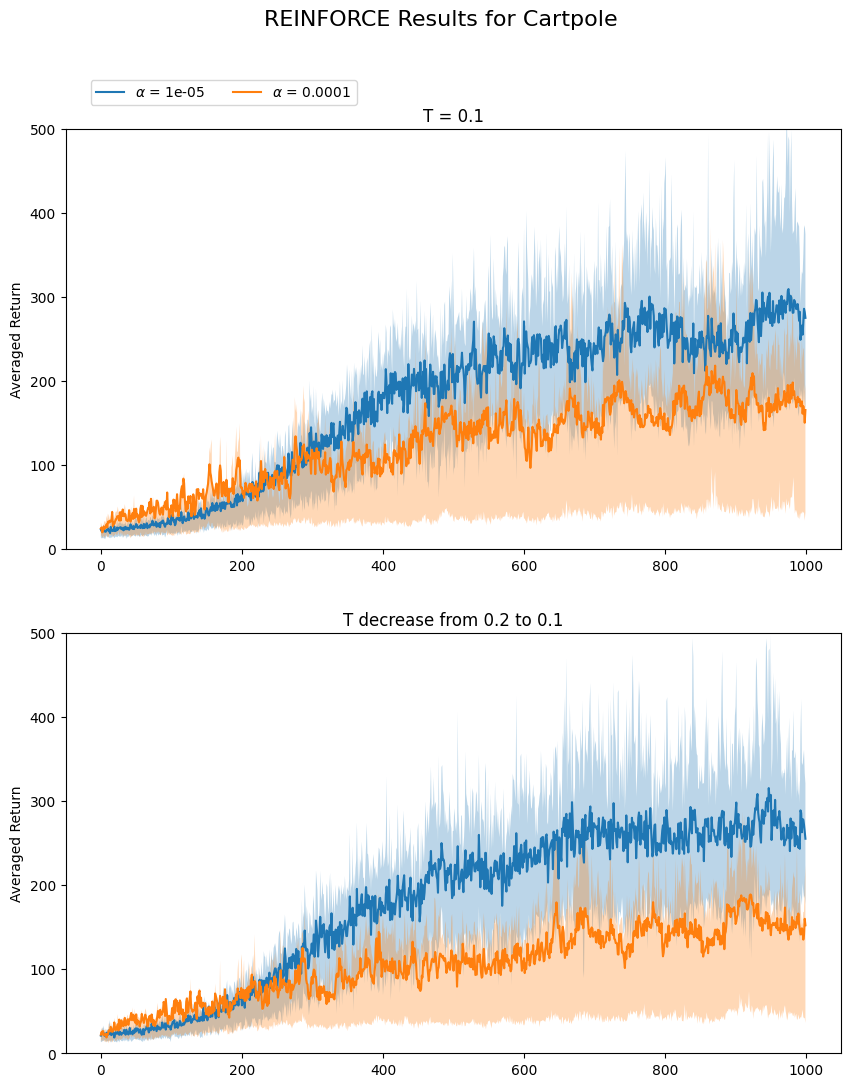

In [131]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

#print(learning_return[0])

plt.rcParams["figure.figsize"]=10,5


for i, learning in enumerate(CP_RF_return):

  for j, alpha_data in enumerate(learning):
    ar_1_mean = np.mean(alpha_data, axis = 0)
    par_1_75, par_1_25 = np.percentile(alpha_data, [75, 25], axis = 0)
    if i == 0:
      axs[i].plot(range(episodes), ar_1_mean, label = f'${{\\alpha}}$ = {alpha[j]}')
      axs[i].set_title(f'T = {temp[i]}')
    else:
      axs[i].plot(range(episodes), ar_1_mean)
      axs[i].set_title(f'T decrease from 0.1 to 0.01')
    axs[i].fill_between(range(episodes), par_1_25, par_1_75, alpha=0.3)

    

plt.setp(axs, ylim=[0, 500], ylabel = 'Averaged Return')
fig.suptitle('REINFORCE Results for Cartpole', fontsize = 16)

fig.legend(bbox_to_anchor=(0.15, 0.9, 1., .102), loc='lower left',
                      ncol=3, borderaxespad=0.)



In [37]:
#env = gym.make("MountainCar-v0")
env = gym.make("MountainCar-v0").env
env._max_episode_steps = 500
obs = env.reset()

#define the parameters
temp = [10, 1]
bins = 10
num_tiles = 5 
alpha = [1/4, 1/8]
trials = 5
gamma = 0.99 
episodes = 500


In [38]:
MC_RF_return = []
for i in range(2):
  learning_return = []
  for a in range(len(alpha)):
    if i == 0:
      temp = np.ones(episodes)*temp[0]
    else:
      temperature = np.linspace(0.1, 0.01, episodes)
    avg_return = REINFORCE_implement(env, tilecoding_Mountain(env, num_tiles, bins), alpha[a], temp, num_tiles, bins)
    learning_return.append(avg_return)
  MC_RF_return.append(learning_return)

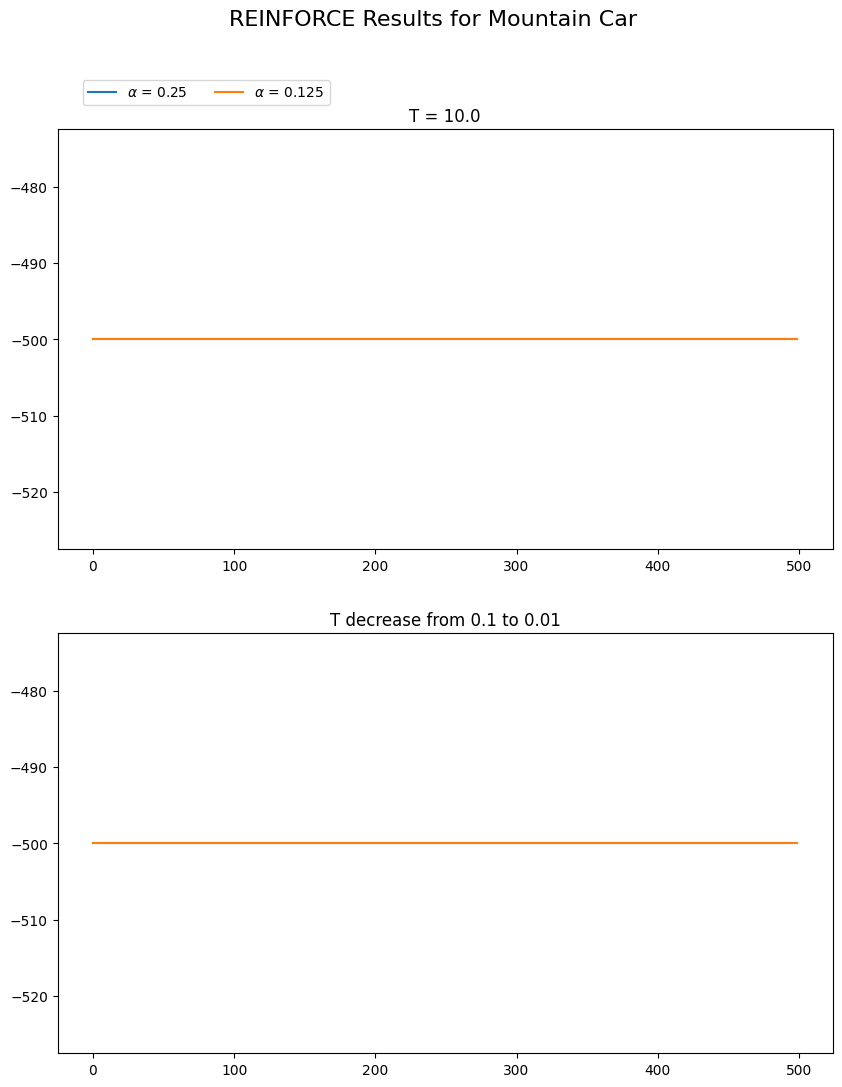

In [39]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

#print(learning_return[0])

plt.rcParams["figure.figsize"]=10,5


for i, learning in enumerate(MC_RF_return):

  for j, alpha_data in enumerate(learning):
    ar_1_mean = np.mean(alpha_data, axis = 0)
    par_1_75, par_1_25 = np.percentile(alpha_data, [75, 25], axis = 0)
    if i == 0:
      axs[i].plot(range(episodes), ar_1_mean, label = f'${{\\alpha}}$ = {alpha[j]}')
      axs[i].set_title(f'T = {temp[i]}')
    else:
      axs[i].plot(range(episodes), ar_1_mean)
      axs[i].set_title(f'T decrease from 0.1 to 0.01')
    axs[i].fill_between(range(episodes), par_1_25, par_1_75, alpha=0.3)

    

#plt.setp(axs, ylim=[-210, -100], ylabel = 'Averaged Return')
fig.suptitle('REINFORCE Results for Mountain Car', fontsize = 16)

fig.legend(bbox_to_anchor=(0.15, 0.9, 1., .102), loc='lower left',
                      ncol=3, borderaxespad=0.)